<a href="https://colab.research.google.com/github/Sirfowahid/BreastCancerDetection/blob/main/Final_Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
save_dir = '/content/drive/MyDrive/Projects/21. Breast Cancer MRI Detection/model_weights/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
model_paths = {
    'vgg16': save_dir+'vgg16_weights.pth',
    'mobilenet': save_dir+'mobilenet_weights.pth',
    'resnet50': save_dir+'resnet50_weights.pth',
    'efficientnet': save_dir+'efficientnet_weights.pth',
    'densenet': save_dir+'densenet_weights.pth'
}

# Data Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Projects/21. Breast Cancer MRI Detection/Dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Projects/21. Breast Cancer MRI Detection/Dataset/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
classnames = train_dataset.classes
print(classnames)

['Ductal Carcinoma', 'Inflammatory Breast Cancer', 'Lipoma', 'Normal breast', 'Triple Negative']


# Model Training

In [ ]:
models_dict = {
    'vgg16': models.vgg16(pretrained=True),
    'mobilenet': models.mobilenet_v2(pretrained=True),
    'resnet50': models.resnet50(pretrained=True),
    'efficientnet': models.efficientnet_b0(pretrained=True),
    'densenet': models.densenet121(pretrained=True)
}

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 138MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s] 
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 127MB/s]


In [ ]:
for name, model in models_dict.items():
    if 'classifier' in dir(model):  # VGG16, MobileNet
        if isinstance(model.classifier, nn.Sequential):  # VGG16 case
            num_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(num_features, len(train_dataset.classes))
        else:  # MobileNet case
            num_features = model.classifier.in_features
            model.classifier = nn.Linear(num_features, len(train_dataset.classes))
    elif 'fc' in dir(model):  # ResNet50
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, len(train_dataset.classes))
    elif 'classifier' in dir(model.features):  # EfficientNet
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(train_dataset.classes))
    elif 'classifier' in dir(model):  # DenseNet
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, len(train_dataset.classes))

    model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizers = {name: optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) for name, model in models_dict.items()}
schedulers = {name: optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) for name, optimizer in optimizers.items()}

In [ ]:
def train_and_validate(model, optimizer, model_name, num_epochs=20):
    if os.path.exists(model_paths[model_name]):
        print(f"Loading saved weights for {model_name}...")
        model.load_state_dict(torch.load(model_paths[model_name]))

        # Evaluate the model with loaded weights
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Evaluating Loaded Model"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        print(f"Validation Accuracy (Loaded Model): {val_accuracy:.2f}%")

        return model

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0  # Track the best validation accuracy

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_paths[model_name])
            print(f"Best model saved with validation accuracy: {val_accuracy:.2f}%")

    # Plot loss graph
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return metrics for further analysis
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }


Validation Epoch 1/20: 100%|██████████| 8/8 [00:50<00:00,  6.27s/it]


Epoch 1/20, Train Loss: 2.0189, Train Acc: 19.52%, Val Loss: 1.7298, Val Acc: 19.92%
Best model saved with validation accuracy: 19.92%


Validation Epoch 2/20: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Epoch 2/20, Train Loss: 1.7130, Train Acc: 15.54%, Val Loss: 1.6096, Val Acc: 19.92%


Validation Epoch 3/20: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 3/20, Train Loss: 1.6544, Train Acc: 19.12%, Val Loss: 1.6157, Val Acc: 19.12%


Validation Epoch 4/20: 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 4/20, Train Loss: 1.6319, Train Acc: 17.93%, Val Loss: 1.6155, Val Acc: 19.92%


Validation Epoch 5/20: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 5/20, Train Loss: 1.6290, Train Acc: 21.51%, Val Loss: 1.6204, Val Acc: 20.72%
Best model saved with validation accuracy: 20.72%


Validation Epoch 6/20: 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Epoch 6/20, Train Loss: 1.6212, Train Acc: 18.73%, Val Loss: 1.6070, Val Acc: 21.12%
Best model saved with validation accuracy: 21.12%


Validation Epoch 7/20: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Epoch 7/20, Train Loss: 1.6115, Train Acc: 19.12%, Val Loss: 1.5704, Val Acc: 28.29%
Best model saved with validation accuracy: 28.29%


Validation Epoch 8/20: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 8/20, Train Loss: 1.6066, Train Acc: 21.12%, Val Loss: 1.6378, Val Acc: 20.72%


Validation Epoch 9/20: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch 9/20, Train Loss: 1.6468, Train Acc: 13.55%, Val Loss: 1.6115, Val Acc: 19.52%


Validation Epoch 10/20: 100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 10/20, Train Loss: 1.6187, Train Acc: 20.72%, Val Loss: 1.6128, Val Acc: 20.72%


Validation Epoch 11/20: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]


Epoch 11/20, Train Loss: 1.6235, Train Acc: 20.32%, Val Loss: 1.6110, Val Acc: 19.92%


Validation Epoch 12/20: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch 12/20, Train Loss: 1.6181, Train Acc: 17.53%, Val Loss: 1.6105, Val Acc: 19.92%


Validation Epoch 13/20: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 13/20, Train Loss: 1.6162, Train Acc: 19.12%, Val Loss: 1.6097, Val Acc: 20.72%


Validation Epoch 14/20: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


Epoch 14/20, Train Loss: 1.6060, Train Acc: 20.32%, Val Loss: 1.6128, Val Acc: 20.72%


Validation Epoch 15/20: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


Epoch 15/20, Train Loss: 1.6216, Train Acc: 19.12%, Val Loss: 1.5955, Val Acc: 22.71%


Validation Epoch 16/20: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


Epoch 16/20, Train Loss: 1.6252, Train Acc: 19.52%, Val Loss: 1.6224, Val Acc: 13.94%


Validation Epoch 17/20: 100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


Epoch 17/20, Train Loss: 1.6459, Train Acc: 23.11%, Val Loss: 1.5949, Val Acc: 23.11%


Validation Epoch 18/20: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 18/20, Train Loss: 1.6222, Train Acc: 21.51%, Val Loss: 1.6123, Val Acc: 21.51%


Validation Epoch 19/20: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Epoch 19/20, Train Loss: 1.6236, Train Acc: 19.92%, Val Loss: 1.6112, Val Acc: 19.92%


Validation Epoch 20/20: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch 20/20, Train Loss: 1.6258, Train Acc: 18.33%, Val Loss: 1.6190, Val Acc: 19.52%


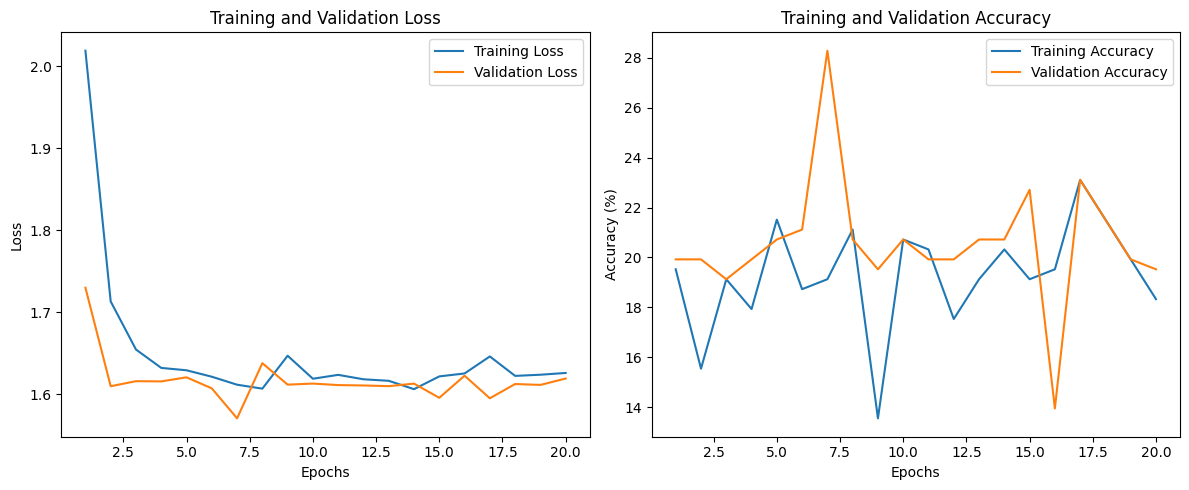

Loading saved weights for mobilenet...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


Validation Accuracy (Loaded Model): 86.45%
Loading saved weights for resnet50...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Validation Accuracy (Loaded Model): 85.26%
Loading saved weights for efficientnet...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


Validation Accuracy (Loaded Model): 86.45%
Loading saved weights for densenet...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

Validation Accuracy (Loaded Model): 85.26%


In [ ]:
trained_models = [train_and_validate(model, optimizers[name], name) for name, model in models_dict.items()]

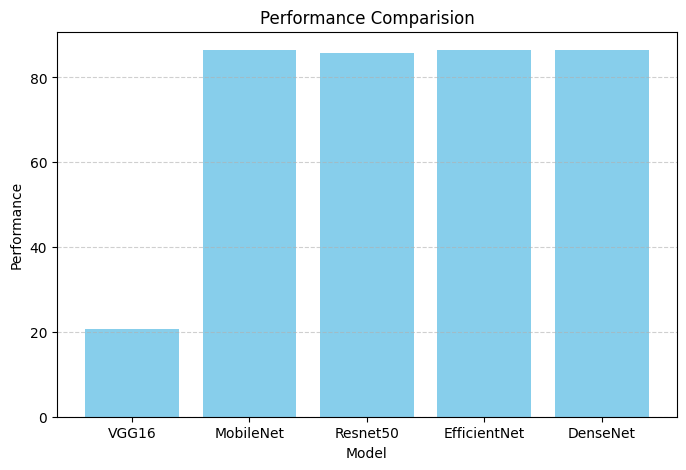

In [ ]:
data = {
    "VGG16": 20.72,
    "MobileNet": 86.45,
    "Resnet50": 85.66,
    "EfficientNet": 86.45,
    "DenseNet":86.45
}

# Extracting keys and values
keys = list(data.keys())
values = list(data.values())

# Creating the bar plot
plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('Performance Comparision')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Ensemble Learning

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

def ensemble_prediction(models, dataloader):
    accuracies = [evaluate_model(model, dataloader) for model in models]
    total_accuracy = sum(accuracies)
    weights = [acc / total_accuracy for acc in accuracies]

    all_preds, all_labels = [], []

    for inputs, labels in tqdm(dataloader, desc='Ensemble Prediction'):
        inputs = inputs.to(device)
        ensemble_outputs = torch.zeros((inputs.size(0), len(train_dataset.classes))).to(device)

        for model, weight in zip(models, weights):
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                ensemble_outputs += torch.softmax(outputs, dim=1) * weight

        preds = torch.argmax(ensemble_outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)


# Prediction and Evaluation

In [ ]:
trained_models = [train_and_validate(model, optimizers[name], name) for name, model in models_dict.items()]

Loading saved weights for vgg16...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Validation Accuracy (Loaded Model): 28.29%
Loading saved weights for mobilenet...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Validation Accuracy (Loaded Model): 86.45%
Loading saved weights for resnet50...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Validation Accuracy (Loaded Model): 85.26%
Loading saved weights for efficientnet...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]


Validation Accuracy (Loaded Model): 86.45%
Loading saved weights for densenet...


Evaluating Loaded Model: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

Validation Accuracy (Loaded Model): 85.26%


In [ ]:
ensemble_preds, ensemble_labels = ensemble_prediction(trained_models[1:], val_loader)

Ensemble Prediction: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


In [ ]:
print("Classification Report:\n", classification_report(ensemble_labels, ensemble_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        50
           1       0.96      0.85      0.90        52
           2       0.89      0.98      0.93        49
           3       0.83      0.58      0.68        50
           4       0.77      0.92      0.84        50

    accuracy                           0.86       251
   macro avg       0.87      0.87      0.86       251
weighted avg       0.87      0.86      0.86       251



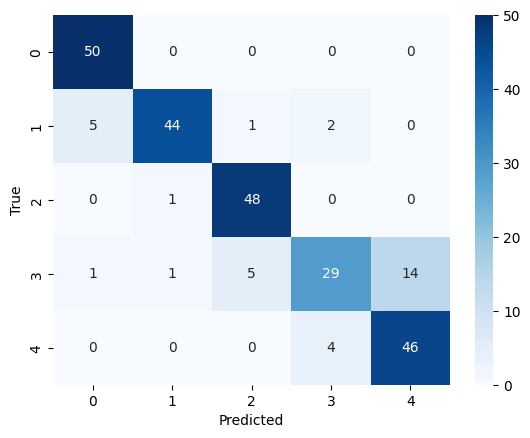

In [ ]:
sns.heatmap(confusion_matrix(ensemble_labels, ensemble_preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.pdf')
plt.show()

Evaluating Models: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


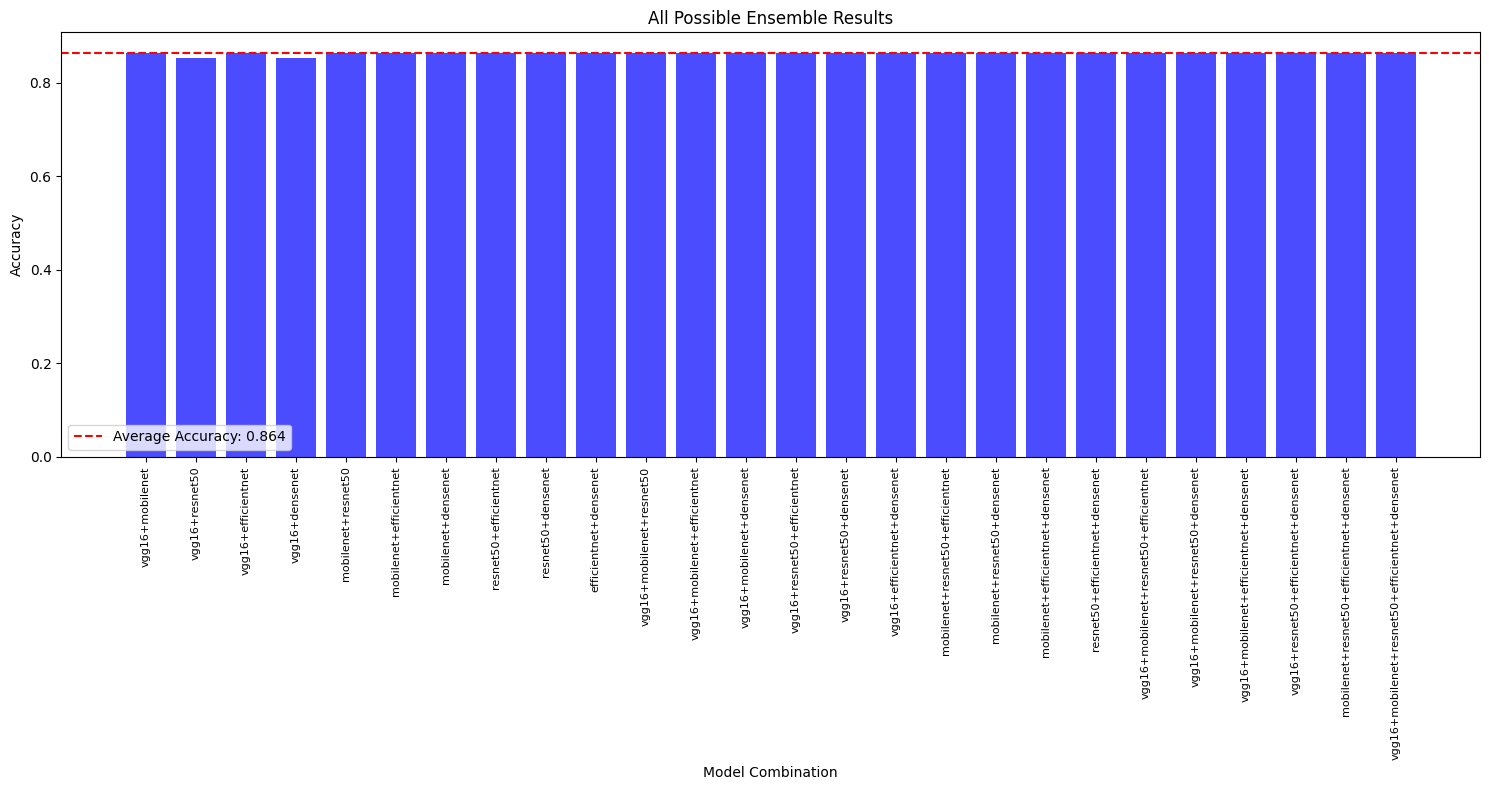

In [ ]:
from itertools import combinations
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Generate all possible combinations of models
def evaluate_ensemble(models, dataloader):
    preds_list, labels_list = [], []

    for inputs, labels in tqdm(dataloader, desc='Evaluating Models'):
        inputs = inputs.to(device)
        labels_list.extend(labels.numpy())
        ensemble_preds = []

        for model in models:
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                ensemble_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())

        preds_list.append(np.mean(ensemble_preds, axis=0))  # Average predictions across models

    return np.vstack(preds_list), np.array(labels_list)

# Compute accuracy for all possible model combinations
model_names = list(models_dict.keys())
all_combinations = []
accuracies = []

for r in range(2, len(trained_models) + 1):
    for combo in combinations(trained_models, r):
        combo_preds, combo_labels = evaluate_ensemble(combo, val_loader)
        combo_preds = np.argmax(combo_preds, axis=1)
        accuracy = accuracy_score(combo_labels, combo_preds)
        all_combinations.append('+'.join([model_names[i] for i in range(len(trained_models)) if trained_models[i] in combo]))
        accuracies.append(accuracy)

# Bar Plot of Ensemble Results
plt.figure(figsize=(15, 8))
plt.bar(range(len(all_combinations)), accuracies, color='blue', alpha=0.7)
plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', label=f"Average Accuracy: {np.mean(accuracies):.3f}")
plt.xticks(range(len(all_combinations)), all_combinations, rotation=90, fontsize=8)
plt.ylabel('Accuracy')
plt.xlabel('Model Combination')
plt.title('All Possible Ensemble Results')
plt.legend()
plt.tight_layout()
plt.savefig('ensemble_results.pdf')  # Save the plot as a PDF
plt.show()


# ROC Curve

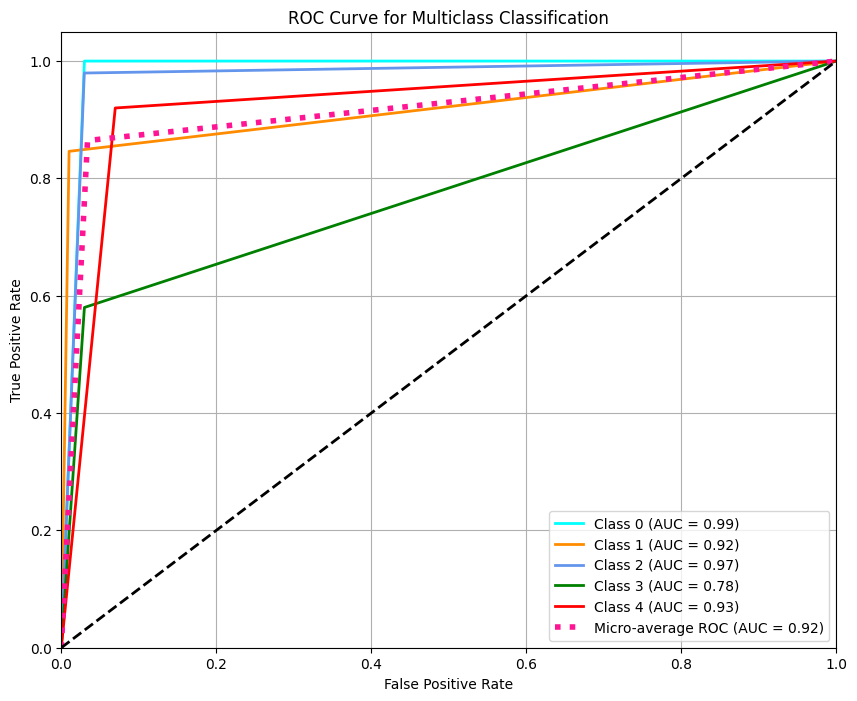

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Number of classes (5 classes in this case)
n_classes = 5

# Binarize the labels for multiclass ROC calculation
ensemble_labels_bin = label_binarize(ensemble_labels, classes=np.arange(n_classes))
ensemble_preds_bin = label_binarize(ensemble_preds, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ensemble_labels_bin[:, i], ensemble_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ensemble_labels_bin.ravel(), ensemble_preds_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
import torch
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_num_classes(model):
    if hasattr(model, 'fc'):
        return model.fc.out_features
    elif hasattr(model, 'classifier'):
        return model.classifier[-1].out_features
    else:
        raise AttributeError("The model does not have a recognized output layer attribute.")

def ensemble_predict_single_image(models, image):
    image = transform(image).unsqueeze(0).to(device)
    num_classes = get_num_classes(models[0])
    ensemble_output = torch.zeros((1, num_classes)).to(device)

    for model in models:
        model.eval()
        with torch.no_grad():
            output = model(image)
            ensemble_output += torch.softmax(output, dim=1)

    ensemble_output /= len(models)
    predicted_class = torch.argmax(ensemble_output, dim=1).item()
    predicted_probabilities = ensemble_output.cpu().numpy()

    return predicted_class, predicted_probabilities

def modify_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    alpha = 2.0
    beta = 0
    contrasted_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    return contrasted_img


In [ ]:
! pip install ultralytics

# Demo

Saving BC_39.jpg to BC_39.jpg

0: 256x256 2 Ductal-Carcinomas, 24.4ms
Speed: 1.1ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 256)


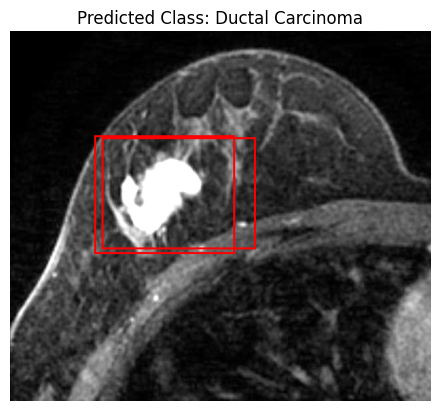

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

# Load a model
model = YOLO("/content/drive/MyDrive/Projects/21. Breast Cancer MRI Detection/best.pt")  # pretrained YOLO model

# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Open and convert the uploaded image to RGB
input_image = Image.open(image_path).convert('RGB')

# Run inference with a lower confidence threshold
results = model.predict(input_image, conf=0.1)

# Obtain the predicted class and class name from the ensemble model
predicted_class, predicted_probabilities = ensemble_predict_single_image(trained_models, input_image)
predicted_class_name = classnames[predicted_class]

# Apply custom modifications to the image
modified_image = modify_image(image_path)

# Convert modified image to PIL format if it's a numpy array
if isinstance(modified_image, np.ndarray):
    modified_image = Image.fromarray(modified_image)

# Draw bounding boxes on the modified image if detections are found
if results and results[0].boxes is not None and len(results[0].boxes) > 0:
    draw = ImageDraw.Draw(modified_image)
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # Extract bounding box coordinates
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)  # Draw bounding box

# Display the modified image with bounding boxes and predicted class name
plt.imshow(modified_image)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')
plt.show()

# Save the image with bounding boxes to disk
modified_image.save("result_with_boxes.jpg")
